In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

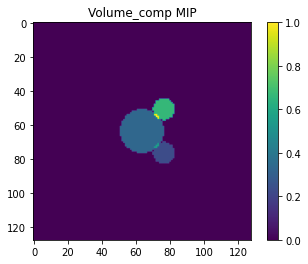

In [3]:
nx = 128
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, X, Y, Z, _, _, _ = volume_fourier(jnp.fft.ifftshift(vol), dimensions)

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

Resize the Fourier grid etc to work with the lower frequencies only

In [121]:
radius = 1

x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# Important for the grids to not be jax (aka Tracer)  objects
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

vol_fourier_small, x_grid_small, y_grid_small, z_grid_small = rescale_smaller_grid(vol_fourier, x_grid, y_grid, z_grid, radius)

L = 2*radius/(2 - jnp.sqrt(2))
print("L = ", L)
nx_small = (jnp.floor(L/x_grid[0]) + 1).astype(jnp.int64)
print("nx_small = ", nx_small)
# Make the grid a little big bigger and add zero padding
vol_fourier_small, x_grid_small, y_grid_small, z_grid_small = rescale_larger_grid(vol_fourier_small, x_grid_small, y_grid_small, z_grid_small, 
                                                                                  [nx_small, nx_small, nx_small])
#vol_fourier_small, x_grid_small, y_grid_small, z_grid_small = rescale_larger_grid(vol_fourier_small, x_grid_small, y_grid_small, z_grid_small, [128,128,128])




x_freq_small = jnp.fft.fftfreq(int(x_grid_small[1]), 1/(x_grid_small[0]*x_grid_small[1]))
y_freq_small = jnp.fft.fftfreq(int(y_grid_small[1]), 1/(y_grid_small[0]*y_grid_small[1]))
z_freq_small = jnp.fft.fftfreq(int(z_grid_small[1]), 1/(z_grid_small[0]*z_grid_small[1]))
X_small, Y_small, Z_small = jnp.meshgrid(x_freq_small, y_freq_small, z_freq_small)

mask = create_mask(X_small, Y_small, Z_small , (0,0,0),radius)

L =  3.414213562373096
nx_small =  69


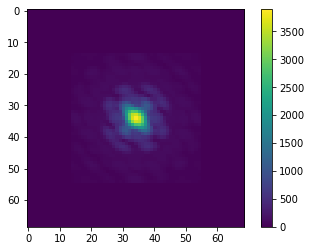

In [122]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier_small)))); plt.colorbar()

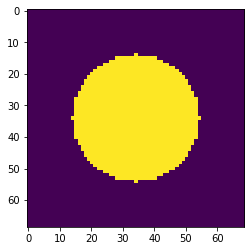

In [123]:
mip_z(jnp.fft.fftshift(mask))

In [124]:
print(x_grid_small)
print(y_grid)
print(z_grid)
print(vol_fourier.shape)

[0.05, DeviceArray(69, dtype=int64)]
[5.00e-02 1.28e+02]
[5.00e-02 1.28e+02]
(128, 128, 128)


Generate projections (in Fourier domain)

In [125]:
@jax.jit
def slice_func(v, angles):
    projection, _ = project(mask * v, x_grid_small, y_grid_small, z_grid_small, angles)
    return projection

@jax.jit
def slice_func_array(v, angles):    
    return jax.vmap(slice_func, in_axes = (None, 0))(v, angles)

In [126]:
N = 1000
angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(vol_fourier_small, angles_true)
print(time.time()-start)

0.8776772022247314


In [127]:
jnp.sum(mask[:,:,0])

DeviceArray(1257., dtype=float64)

In [128]:
imgs.shape

(1000, 4761)

Loss function given volume and angles, for one image and for many (batches of images). We have a separate loss function for each angles-image pair.

In [129]:
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, img):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    return 1/(2* 1245) * l2sq(slice_func(v, angles) - img)   #1257 = number of pixels in mask at z=0


@jax.jit
def loss_func_batched(v, angles, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0))(v, angles, imgs)

And the gradients of the above, with respect to angles

In [130]:
@jax.jit
def grad_loss_angles(v, angles, img):
    return jax.grad(loss_func, argnums = 1)(v, angles, img)

@jax.jit
def grad_loss_angles_batched(v, angles, imgs):
    return jax.vmap(grad_loss_angles, in_axes = (None, 0, 0))(v, angles, imgs)

In [131]:
start = time.time()
ll = loss_func_batched(vol_fourier_small, angles_true, imgs)
print(time.time()-start)
print(ll.shape)

0.8092477321624756
(1000,)


In [132]:
start = time.time()
dl = grad_loss_angles(vol_fourier_small, angles_true[0], imgs[0])
print(time.time()-start)
print(dl.shape)

1.316096305847168
(3,)


In [133]:
start = time.time()
dl = grad_loss_angles_batched(vol_fourier_small, angles_true, imgs)
print(time.time()-start)
print(dl.shape)

1.3945093154907227
(1000, 3)


Gradients with respect to volume pixels, over all (or a batch of) images

In [134]:
@jax.jit
def grad_loss_volume(v, angles, img):
    return jax.grad(loss_func)(v, angles, img)

@jax.jit
def grad_loss_volume_batched(v, angles, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0))(v, angles, imgs), axis=0)

In [135]:
start = time.time()
ll = grad_loss_volume(vol_fourier_small, angles_true[0], imgs[0])
print(time.time()-start)
print(ll.shape)

0.8050639629364014
(69, 69, 69)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [136]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vol_fourier_small, angles_true[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

1.0795164108276367
(69, 69, 69)


## Gradient descent with respect to angles

In [124]:
alpha = 0.00000001
a = jnp.array(np.random.rand(N, 3)*np.pi*2)
a = jnp.mod(a, 2*jnp.pi)
#a = angles_true + 0.01*a
N_iter = 10

for i in range(N_iter):
        
    if jnp.mod(i,100) == 0:
    #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(vol_fourier_small, a, imgs))))
        
    a = a - alpha * jnp.conj(grad_loss_angles_batched(vol_fourier_small, a, imgs))
    
a = jnp.mod(a, 2*jnp.pi)


    
max_err = jnp.mean(jnp.abs(a - angles_true))
print("mean(a-a_true) = " + str(max_err))

Iter 0: mean loss = 89314.55339447968
mean(a-a_true) = 2.1885634242880436


In [125]:
max_err = jnp.max(jnp.abs(a - angles_true))
print("max(a-a_true) = " + str(max_err))

max(a-a_true) = 6.005620663852082


## Gradient descent with respect to volume

In [138]:
nx_small = vol_fourier_small.shape[0]

v0 = jnp.array(np.random.randn(nx_small,nx_small,nx_small) + 1j * np.random.randn(nx_small,nx_small,nx_small))*jnp.max(jnp.abs(imgs[0])) * mask
#v0 = vol_fourier + 0.1*v * mask
alpha = 1000000 # this alpha works well for full 128 x 128 x 128 volume
#alpha = 100000 
batch_size = 2
N_iter = 1000 * 20
#N_iter = 1000 

v = v0
#idx = jnp.arange(100)
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier_small)/jnp.max(vol_fourier_small))))

Iter 0: mean loss = 4648064.833491056
Iter 100: mean loss = 282993.4794237239
Iter 200: mean loss = 106386.02614531603
Iter 300: mean loss = 16736.503621436827
Iter 400: mean loss = 13062.403191415417
Iter 500: mean loss = 5860.854608769267
Iter 600: mean loss = 1282.7061337181308
Iter 700: mean loss = 951.0694387177252
Iter 800: mean loss = 354.2121271584354
Iter 900: mean loss = 521.9135688624301
Iter 1000: mean loss = 386.69849007413137
Iter 1100: mean loss = 329.51673352406004
Iter 1200: mean loss = 112.7542016281364
Iter 1300: mean loss = 70.29448021101071
Iter 1400: mean loss = 26.067860942304264
Iter 1500: mean loss = 26.14272889907889
Iter 1600: mean loss = 21.39650450908137
Iter 1700: mean loss = 24.251226706164008
Iter 1800: mean loss = 16.043077512643244
Iter 1900: mean loss = 4.5184348402028665
Iter 2000: mean loss = 4.316057888891453
Iter 2100: mean loss = 3.097122238145082
Iter 2200: mean loss = 0.9720304588223936
Iter 2300: mean loss = 1.0046300812420115
Iter 2400: mean 

KeyboardInterrupt: 

In [139]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier_small)/jnp.max(vol_fourier_small))))

Final loss function (over all data) =  4.0558269021398265e-16
Relative error =  0.03421829560907133


Text(0.5, 1.0, 'Volume_comp MIP')

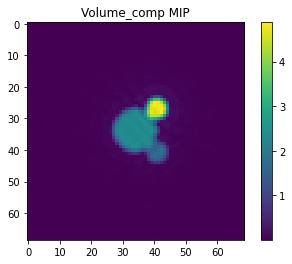

In [140]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Volume_comp MIP')

Text(0.5, 1.0, 'Volume_comp MIP')

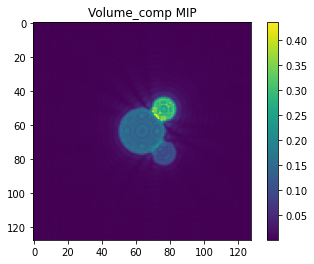

In [141]:
v_large, _,_,_ = rescale_larger_grid(v, x_grid_small, y_grid_small, z_grid_small, [128, 128, 128])
#vol_fourier_large, _,_,_ = rescale_larger_grid(vol_fourier, x_grid, y_grid, z_grid, [nx_small, nx_small, nx_small])

mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_large)))))
#mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier_large)))-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v)))))
plt.colorbar()
plt.title('Volume_comp MIP')

Text(0.5, 1.0, 'Volume_comp MIP')

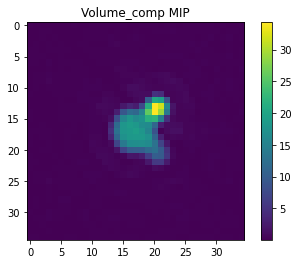

In [ ]:
v_large, _,_,_ = rescale_smaller_grid(v, x_grid_small, y_grid_small, z_grid_small, 3.2)

mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_large))))
plt.colorbar()
plt.title('Volume_comp MIP')

In [147]:
idx = 10
jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(imgs[idx]))).shape

(4761,)